In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import keras
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
%matplotlib inline

Using TensorFlow backend.


In [2]:
def load_data():
    """ Loads the data with information from udacity provided 'drive_log.csv'
        file. Add 2 additional columns or left and right image steering angle
        
        left image steer angle = center image steer angle + correction
        right image steer angle = center image steer angle - correction
        
        correction: the angle required to steer the car back to the center """
    path = 'data/'
    column_names=['center', 'left', 'right', 'Steering Angle', 'throttle', 'break', 'speed']
                    
    data = pd.read_csv('data/driving_log.csv',index_col = False)
    data.columns = column_names

    data['Center Image'] = path + data['center'].apply(str.strip)
    data['Left Image'] = path + data['left'].apply(str.strip)
    data['Right Image'] = path + data['right'].apply(str.strip)

    # Remove data with no throttle
    ind = data['throttle']>0    
    data = data[ind].reset_index(drop=True)
  
    
    # Add left and right image steering angles to the angle correction factor
    # This correction angle was arrived at by estimation. Best correction angle ranges from .2 to .25
    correction = 0.22
    data['Left Steering Angle'] = data['Steering Angle'] + correction
    data['Right Steering Angle'] = data['Steering Angle'] - correction 
    return data

In [3]:
full_data_log = load_data()

In [ ]:
#Print examples for left, center and right images
#Each image has it's associated steering angle label

([], <a list of 0 Text xticklabel objects>)

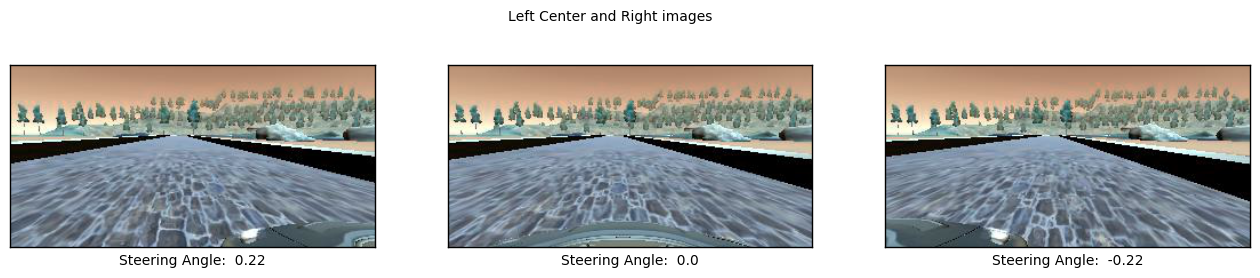

In [4]:
gs = gridspec.GridSpec(1,3)
plt.figure(figsize=(16, 3)).suptitle('Left Center and Right images', y=1, x=.5 )

for i in range(4):
    i_random = np.random.randint(len(data_files_s)-1)
    plt.figure(figsize=(8,16))
    plot_camera_images(data_files_s,steer_sm_s,i_random,0)
    plt.show()

# Display one particular left sided image
plt.subplot(gs[0])
l_image = cv2.imread(full_data_log['Left Image'][50], cv2.COLOR_BGR2RGB)
plt.imshow(l_image)
plt.xlabel('Steering Angle:  ' + str (full_data_log['Left Steering Angle'][120]))
plt.yticks([], []) 
plt.xticks([], [])
    
# Display corresponding  center image
plt.subplot(gs[1])
c_image = cv2.imread(full_data_log['Center Image'][50], cv2.COLOR_BGR2RGB)
plt.imshow(c_image)
plt.xlabel('Steering Angle:  ' + str (full_data_log['Steering Angle'][120]))
plt.yticks([], []) 
plt.xticks([], [])

# Display correspondig right image
plt.subplot(gs[2])
r_image = cv2.imread(full_data_log['Right Image'][50], cv2.COLOR_BGR2RGB)
plt.xlabel('Steering Angle:  ' + str (full_data_log['Right Steering Angle'][120]))
plt.imshow(r_image)
plt.yticks([], []) 
plt.xticks([], [])

In [5]:
training_examples = len(full_data_log)
zero_samples = len(full_data_log[full_data_log['Steering Angle']==0])

print("Total number of Training examples:", training_examples)
print("Number of examples with 0 as steering Angle:", zero_samples)
print("Percentage of examples with 0 as steering angle:", "{:0.2f}%".format( zero_samples/training_examples*100))

Total number of Training examples: 7306
Number of examples with 0 as steering Angle: 3816
Percentage of examples with 0 as steering angle: 52.23%


In [ ]:
#Plot histrogram of udacity data set

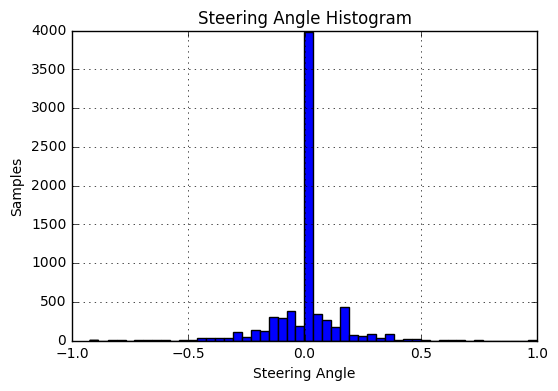

In [6]:
histogram = full_data_log['Steering Angle'].hist(bins=50)
histogram.set_xlabel('Steering Angle')
histogram.set_ylabel('Samples')
histogram.set_title('Steering Angle Histogram')

In [7]:
# The distribution heavily skewed towards angle 0 which infuences the car to drive in a straight line. 
# We can do with some downsampling of 0 angle data before feeding to the neural network like below. Here the 0 angle 
# steering data has been downsampled by 55%

In [9]:
data_set_non_zero = full_data_log[full_data_log["Steering Angle"] != 0.0]
data_set_zero = full_data_log[full_data_log["Steering Angle"] == 0.0].sample(frac=.45, random_state= 42)
down_sampled_data = pd.concat([data_set_non_zero, data_set_zero]).reset_index(drop=True)

total_samples = len(down_sampled_data)
total_zero_samples = len(down_sampled_data[down_sampled_data['Steering Angle']==0])

print("Total number of Training examples:", total_samples)
print("Number of examples with 0 as steering Angle:", total_zero_samples)
print("Percentage of examples with 0 as steering angle:", "{:0.2f}%".format( total_zero_samples/total_samples*100))

Total number of Training examples: 5207
Number of examples with 0 as steering Angle: 1717
Percentage of examples with 0 as steering angle: 32.97%


In [ ]:
#Plot histogram after downsampling of 0 angle data. Looks more uniform as shown below
#Lesson learnt - This proved I could have downsampled the data before feeding into neural netowrk

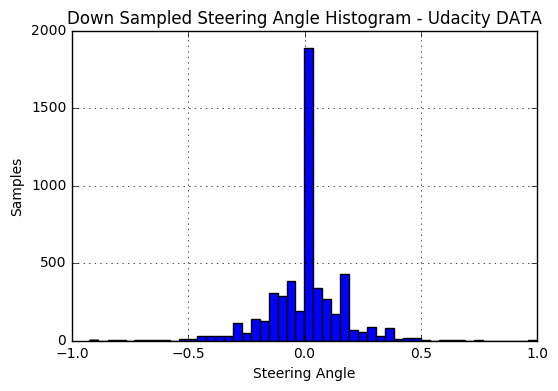

In [10]:
histogram2 = down_sampled_data['Steering Angle'].hist(bins=50)
histogram2.set_xlabel('Steering Angle')
histogram2.set_ylabel('Samples')
histogram2.set_title('Down Sampled Steering Angle Histogram')

In [11]:
def preprocess_image(image, new_row_size, new_col_size):
    """ Takes in a numpy array and converts it HSV color space 
        only keeping the S channel. Resizes the image to 64x64 size
        and crop image to remove the horizon and the hood part of the car"""
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)[:,:,1]
    image = image[40:138]  
    image = cv2.resize(image,(new_row_size, new_col_size), interpolation=cv2.INTER_AREA)
    return image 

In [12]:
def load_training_data(data, new_row_size=64, new_col_size=64):
    """ Takes in a dataframe containing training data information and
        returns preprocessed image data and labels in the form of numpy arrays. Images are resized
        to 64x64"""
    num_samples = len(data)
    label_data = np.zeros(num_samples*3, dtype=np.float32)
    image_data = np.zeros((num_samples*3, new_row_size, new_col_size), dtype=np.float32)
    
    # Load center image data
    for index in range(0, num_samples):
        image_c = cv2.imread(data['Center Image'][index])
        label_data[index] = data['Steering Angle'][index]
        image_data[index] = preprocess_image(image_c, new_row_size, new_col_size)
    
    # Load left image data
    for read_index, write_index in zip(range(num_samples), range(num_samples, num_samples*2)):
        image_l = cv2.imread(data['Left Image'][read_index])
        label_data[write_index] = data['Left Steering Angle'][read_index]
        image_data[write_index] = preprocess_image(image_l, new_row_size, new_col_size)
    
    # Load right image data
    for read_index, write_index in zip(range(num_samples), range(num_samples*2, num_samples*3)):
        image_r = cv2.imread(data['Right Image'][read_index])
        label_data[write_index] = data['Right Steering Angle'][read_index]
        image_data[write_index] = preprocess_image(image_r, new_row_size, new_col_size)
    
    # Add additional dimension to the image - convert (None,64,64) to (None,64,64,1)
    image_data = np.reshape(image_data, (image_data.shape[0],new_row_size,
                                         new_col_size,-1))
    return image_data, label_data

In [16]:
# Preprocess images and load train and test features into numpy arrays
col_size = 64
row_size = 64
train_features, train_labels = load_training_data(full_data_log, row_size, col_size)
    
# Create validation set with a 90-10 split
train_features, train_labels = shuffle(train_features, train_labels)
train_features, valid_features, train_labels, valid_labels = train_test_split(
                                                                              train_features,
                                                                              train_labels,
                                                                              test_size=0.10,
                                                                            random_state=42)

In [17]:
#Sample images after preprocessing (HSV)

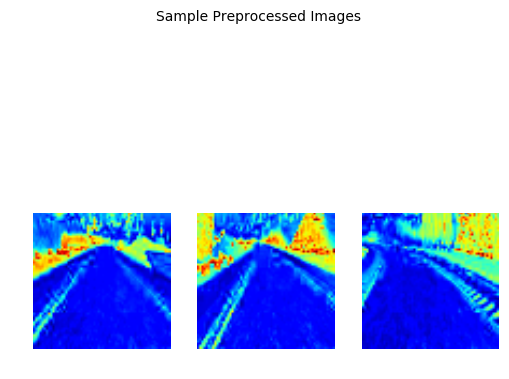

In [22]:
# Plot image in HSV color space
gs3 = gridspec.GridSpec(1,5)
plt.figure(figsize=(6,7)).suptitle('Sample Preprocessed Images', y=.90, x=.50 )
for index in range(3):
    rand_int = np.random.randint(len(train_features))
    plt.subplot(gs[index])
    plt.imshow(train_features[rand_int].squeeze())
    plt.axis('off')

In [23]:
### Import Keras model layers
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dense, Dropout, Activation, Lambda
from keras.layers import Convolution2D, MaxPooling2D, ELU, Flatten
from keras.optimizers import Adam

In [24]:
def LeNet_model():
    # model paramaters
    input_shape = (64, 64, 1)
    filter_size = 3 # extract finer features with a 3x3 filter
    pool_size = (4,4)
    
    # Create model
    model = Sequential()
    
    # Normalize the data
    model.add(Lambda(lambda x: x/255.-0.5, input_shape=input_shape))
    
    # Convolution 1 -> activation -> pooling
    model.add(Convolution2D(6, filter_size, filter_size, init='he_normal', border_mode='valid'))
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=pool_size))
    
    # Convolution 2 -> activation -> pooling
    model.add(Convolution2D(16, filter_size, filter_size, init='he_normal', border_mode='valid'))
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=pool_size))
    
    # Flatten
    model.add(Flatten())
    
    # Fully connected layers
    model.add(Dense(120, init='he_normal'))      # fc1
    model.add(ELU())
    model.add(Dense(84, init='he_normal'))       # fc2
    model.add(ELU())
    model.add(Dense(1, init='he_normal'))        # output
    return model

In [ ]:
#Lenet model summarized below

In [25]:
LeNet_model().summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 64, 64, 1)     0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 62, 62, 6)     60          lambda_1[0][0]                   
____________________________________________________________________________________________________
elu_1 (ELU)                      (None, 62, 62, 6)     0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 15, 15, 6)     0           elu_1[0][0]                      
___________________________________________________________________________________________